In [1]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns

from matplotlib import pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img

## Load data & pre-proccessing

In [2]:
train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'
sample_img = cv.imread('/kaggle/input/fer2013/train/happy/Training_80015.jpg', cv.IMREAD_GRAYSCALE)

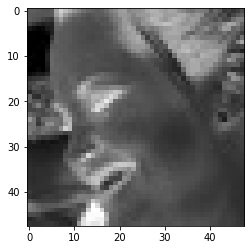

In [3]:
plt.figure(figsize=[4, 4])
plt.imshow(sample_img, cmap=plt.cm.gray_r)

In [4]:
def load_and_masking(src: str, mask: str):
    # load image
    array = cv.imread(src, cv.IMREAD_GRAYSCALE)

    # apply mask to image
    if mask == 'top':
        array[10:25] = 0
    else:
        array[30:] = 0

    return array


def prepare_dataset(src: str, dst: str, mask_on: str = 'top'):
    # create masked dataset
    for i, path in enumerate(os.listdir(src)):
        img_path = os.path.join(src, path)
        array = load_and_masking(img_path, mask_on)
        cv.imwrite(os.path.join(dst, path), array)

        print(f'{i + 1}/{len(os.listdir(src))}', end='\r')

In [5]:
if not os.path.isdir('./train'):
    os.mkdir('./train')

for cat in os.listdir(train_dir):
    src = os.path.join(train_dir, cat)
    dst = os.path.join('./train', cat)

    if not os.path.isdir(dst):
        os.mkdir(dst)

    prepare_dataset(src, dst)
    print()

3171/3171
4097/4097
3995/3995
4965/4965
4830/4830
436/436
7215/7215


In [6]:
if not os.path.isdir('./test'):
    os.mkdir('./test')

for cat in os.listdir(test_dir):
    src = os.path.join(test_dir, cat)
    dst = os.path.join('./test', cat)

    if not os.path.isdir(dst):
        os.mkdir(dst)

    prepare_dataset(src, dst)
    print()

831/831
1024/1024
958/958
1233/1233
1247/1247
111/111
1774/1774


## Model Building

### Configure

In [7]:
train_data_dir = './train'
epochs = 50
lr = 1e-4
valid_split = 0.2
input_size = 300
batch_size = 32
classes = 7
initializer = tf.keras.initializers.HeUniform()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr)
loss = tf.keras.losses.categorical_crossentropy

### Callbacks

In [8]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=15,
                                              monitor='val_loss',
                                              restore_best_weights=True,
                                              verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=2,
                                                 monitor='val_loss',
                                                 factor=0.75,
                                                 verbose=1)

### Data Loder

In [9]:
generator = ImageDataGenerator(rescale=1 / 255,
                               rotation_range=15,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               samplewise_center=True,
                               samplewise_std_normalization=True,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=valid_split)

In [10]:
train_datagen = generator.flow_from_directory(train_data_dir,
                                              target_size=(input_size, input_size),
                                              batch_size=batch_size,
                                              subset='training')

valid_datagen = generator.flow_from_directory(train_data_dir,
                                              target_size=(input_size, input_size),
                                              batch_size=batch_size,
                                              subset='validation')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


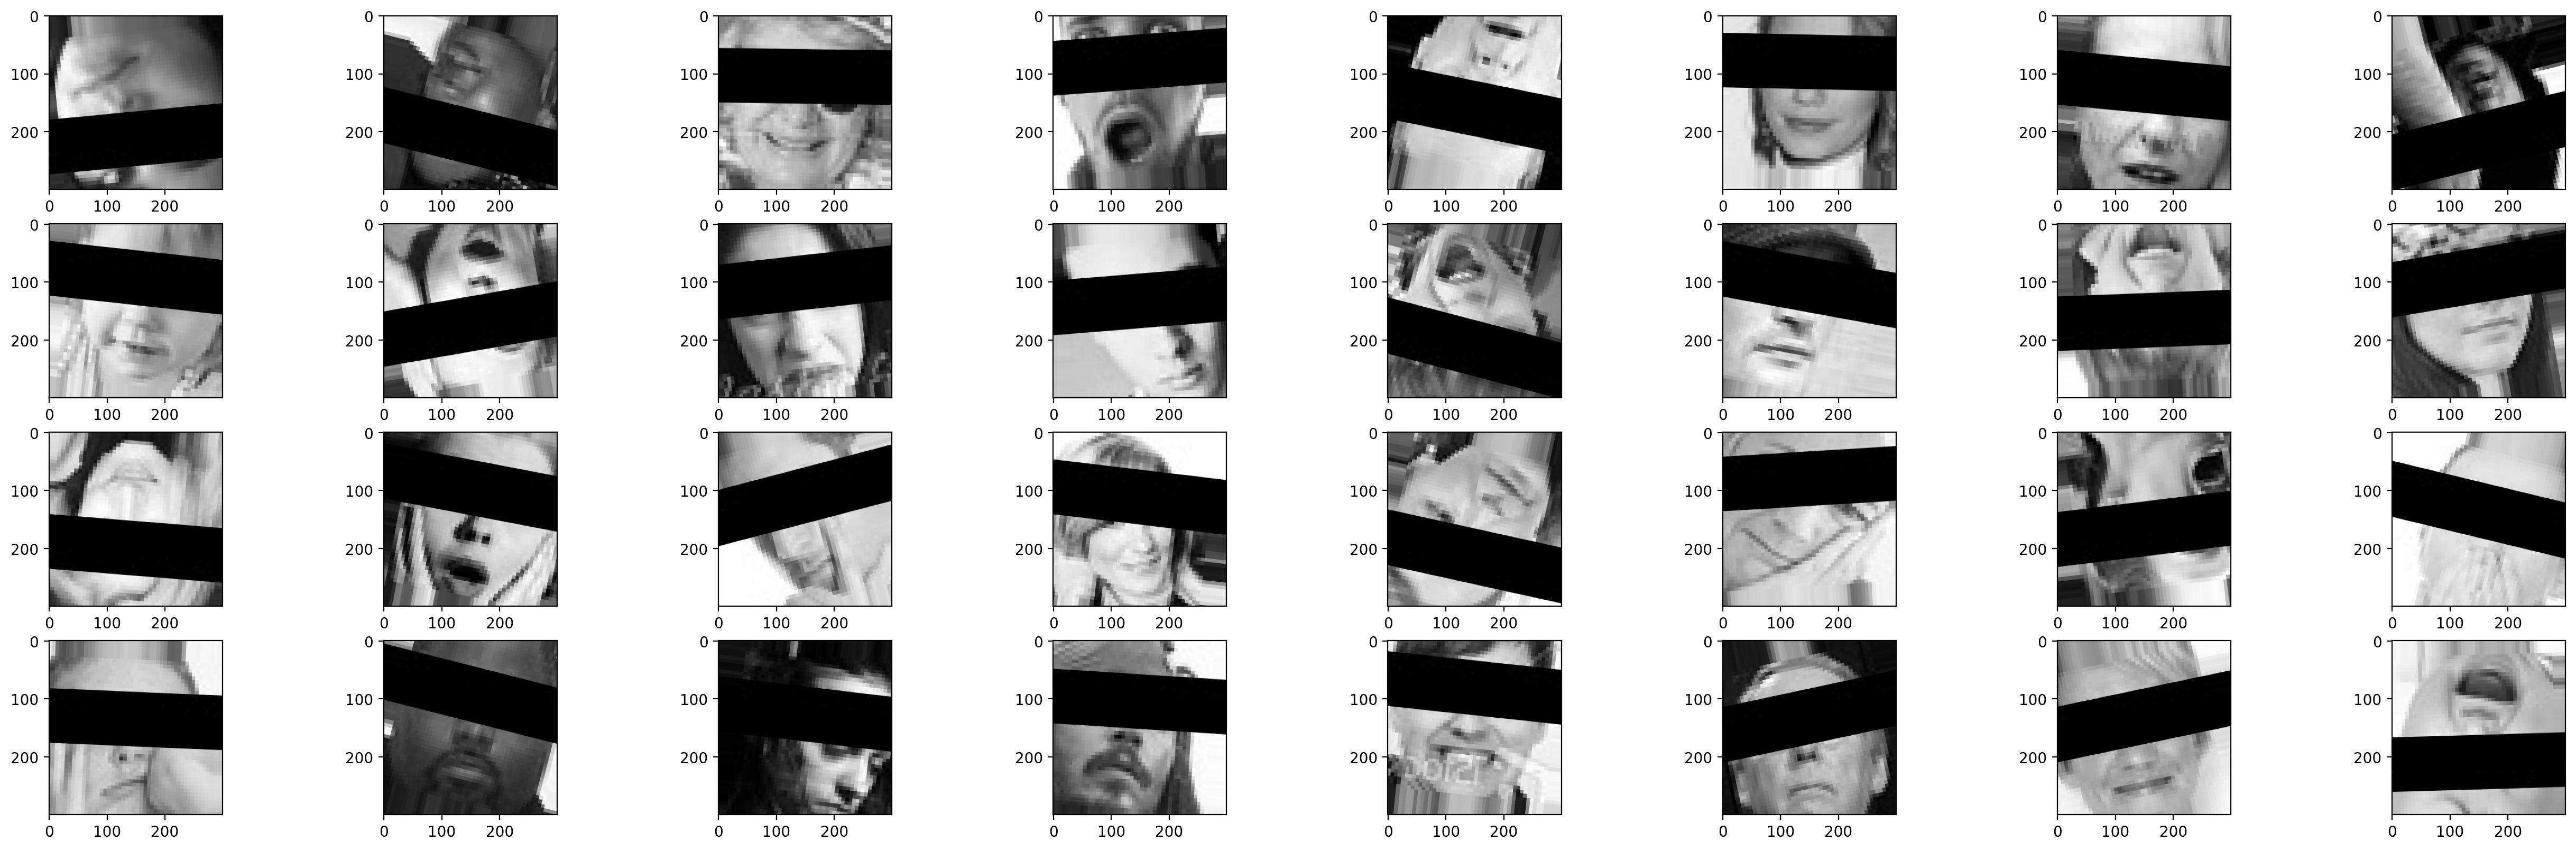

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=[32, 10], dpi=200)
axes = axes.ravel()

for i, arr in enumerate(train_datagen.next()[0]):
    img = array_to_img(arr)
    axes[i].imshow(img)

plt.show()

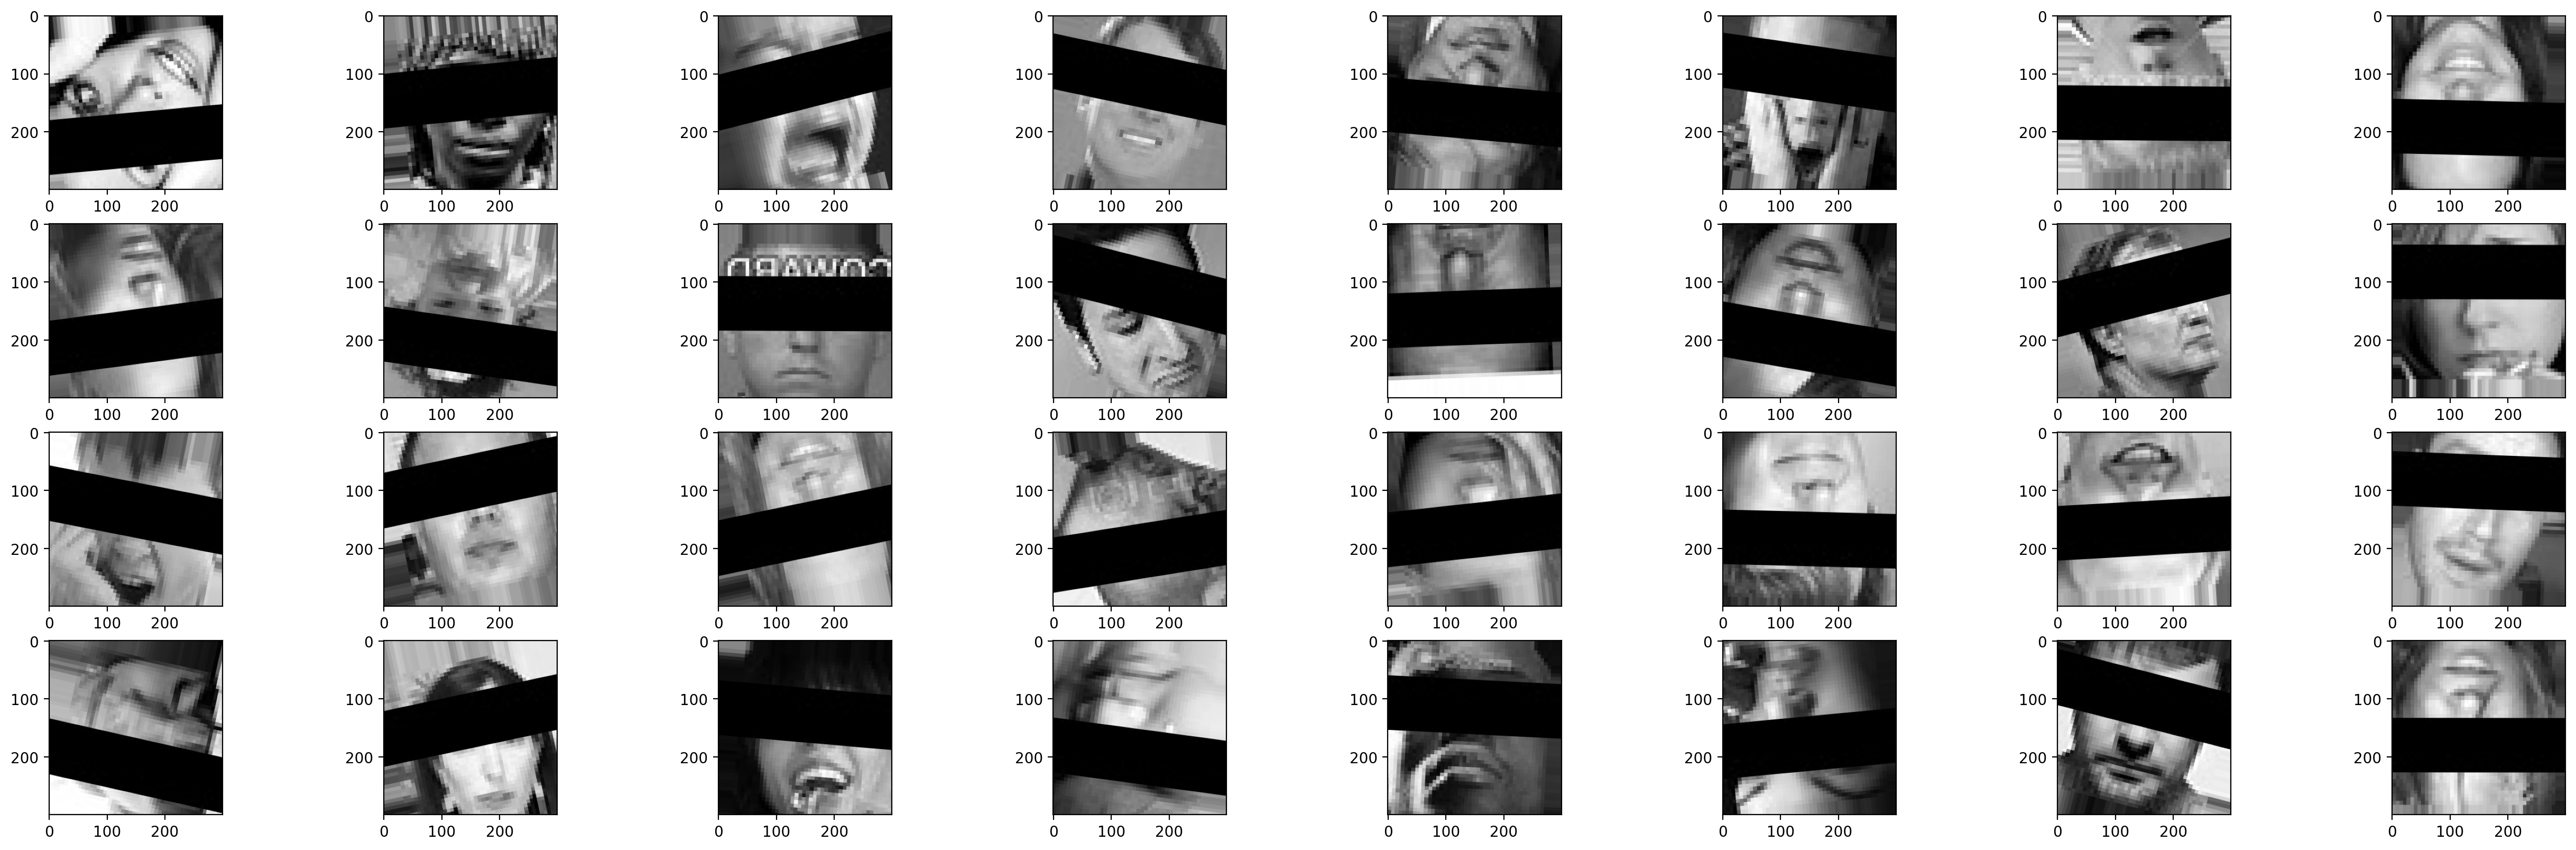

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=[32, 10], dpi=200)
axes = axes.ravel()

for i, arr in enumerate(valid_datagen.next()[0]):
    img = array_to_img(arr)
    axes[i].imshow(img)

plt.show()

### Model

In [13]:
input_ = layers.Input((input_size, input_size, 3))
back_bone = tf.keras.applications.EfficientNetB3(include_top=False,input_tensor=input_)

2022-12-25 05:01:04.453027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 05:01:04.624926: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 05:01:04.625708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 05:01:04.627310: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

43950080/43941136 [==============================] - 0s 0us/step


In [14]:
# back_bone.load_weights('/kaggle/input/mobilenetv2-weights-224/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')

In [15]:
model = Sequential([back_bone,
                    layers.AveragePooling2D((3, 3)),
                    layers.Flatten(),
                    layers.Dense(units=classes, activation=activations.softmax)])

### compilation

In [16]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
average_pooling2d (AveragePo (None, 3, 3, 1536)        0         
_________________________________________________________________
flatten (Flatten)            (None, 13824)             0         
_________________________________________________________________
dense (Dense)                (None, 7)                 96775     
Total params: 10,880,310
Trainable params: 10,793,007
Non-trainable params: 87,303
_________________________________________________________________


### training and validation

In [18]:
history = model.fit(train_datagen,
                    validation_data=valid_datagen,
                    batch_size=batch_size,
                    epochs=1,
                    callbacks=[early_stop, reduce_lr])

2022-12-25 05:01:13.644749: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-25 05:01:44.456119: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


718/718 [==============================] - 839s 1s/step - loss: 1.5018 - accuracy: 0.4172 - val_loss: 1.6603 - val_accuracy: 0.3336


In [19]:
model.evaluate(valid_datagen)

180/180 [==============================] - 122s 678ms/step - loss: 1.6705 - accuracy: 0.3269


[1.6705107688903809, 0.32694652676582336]

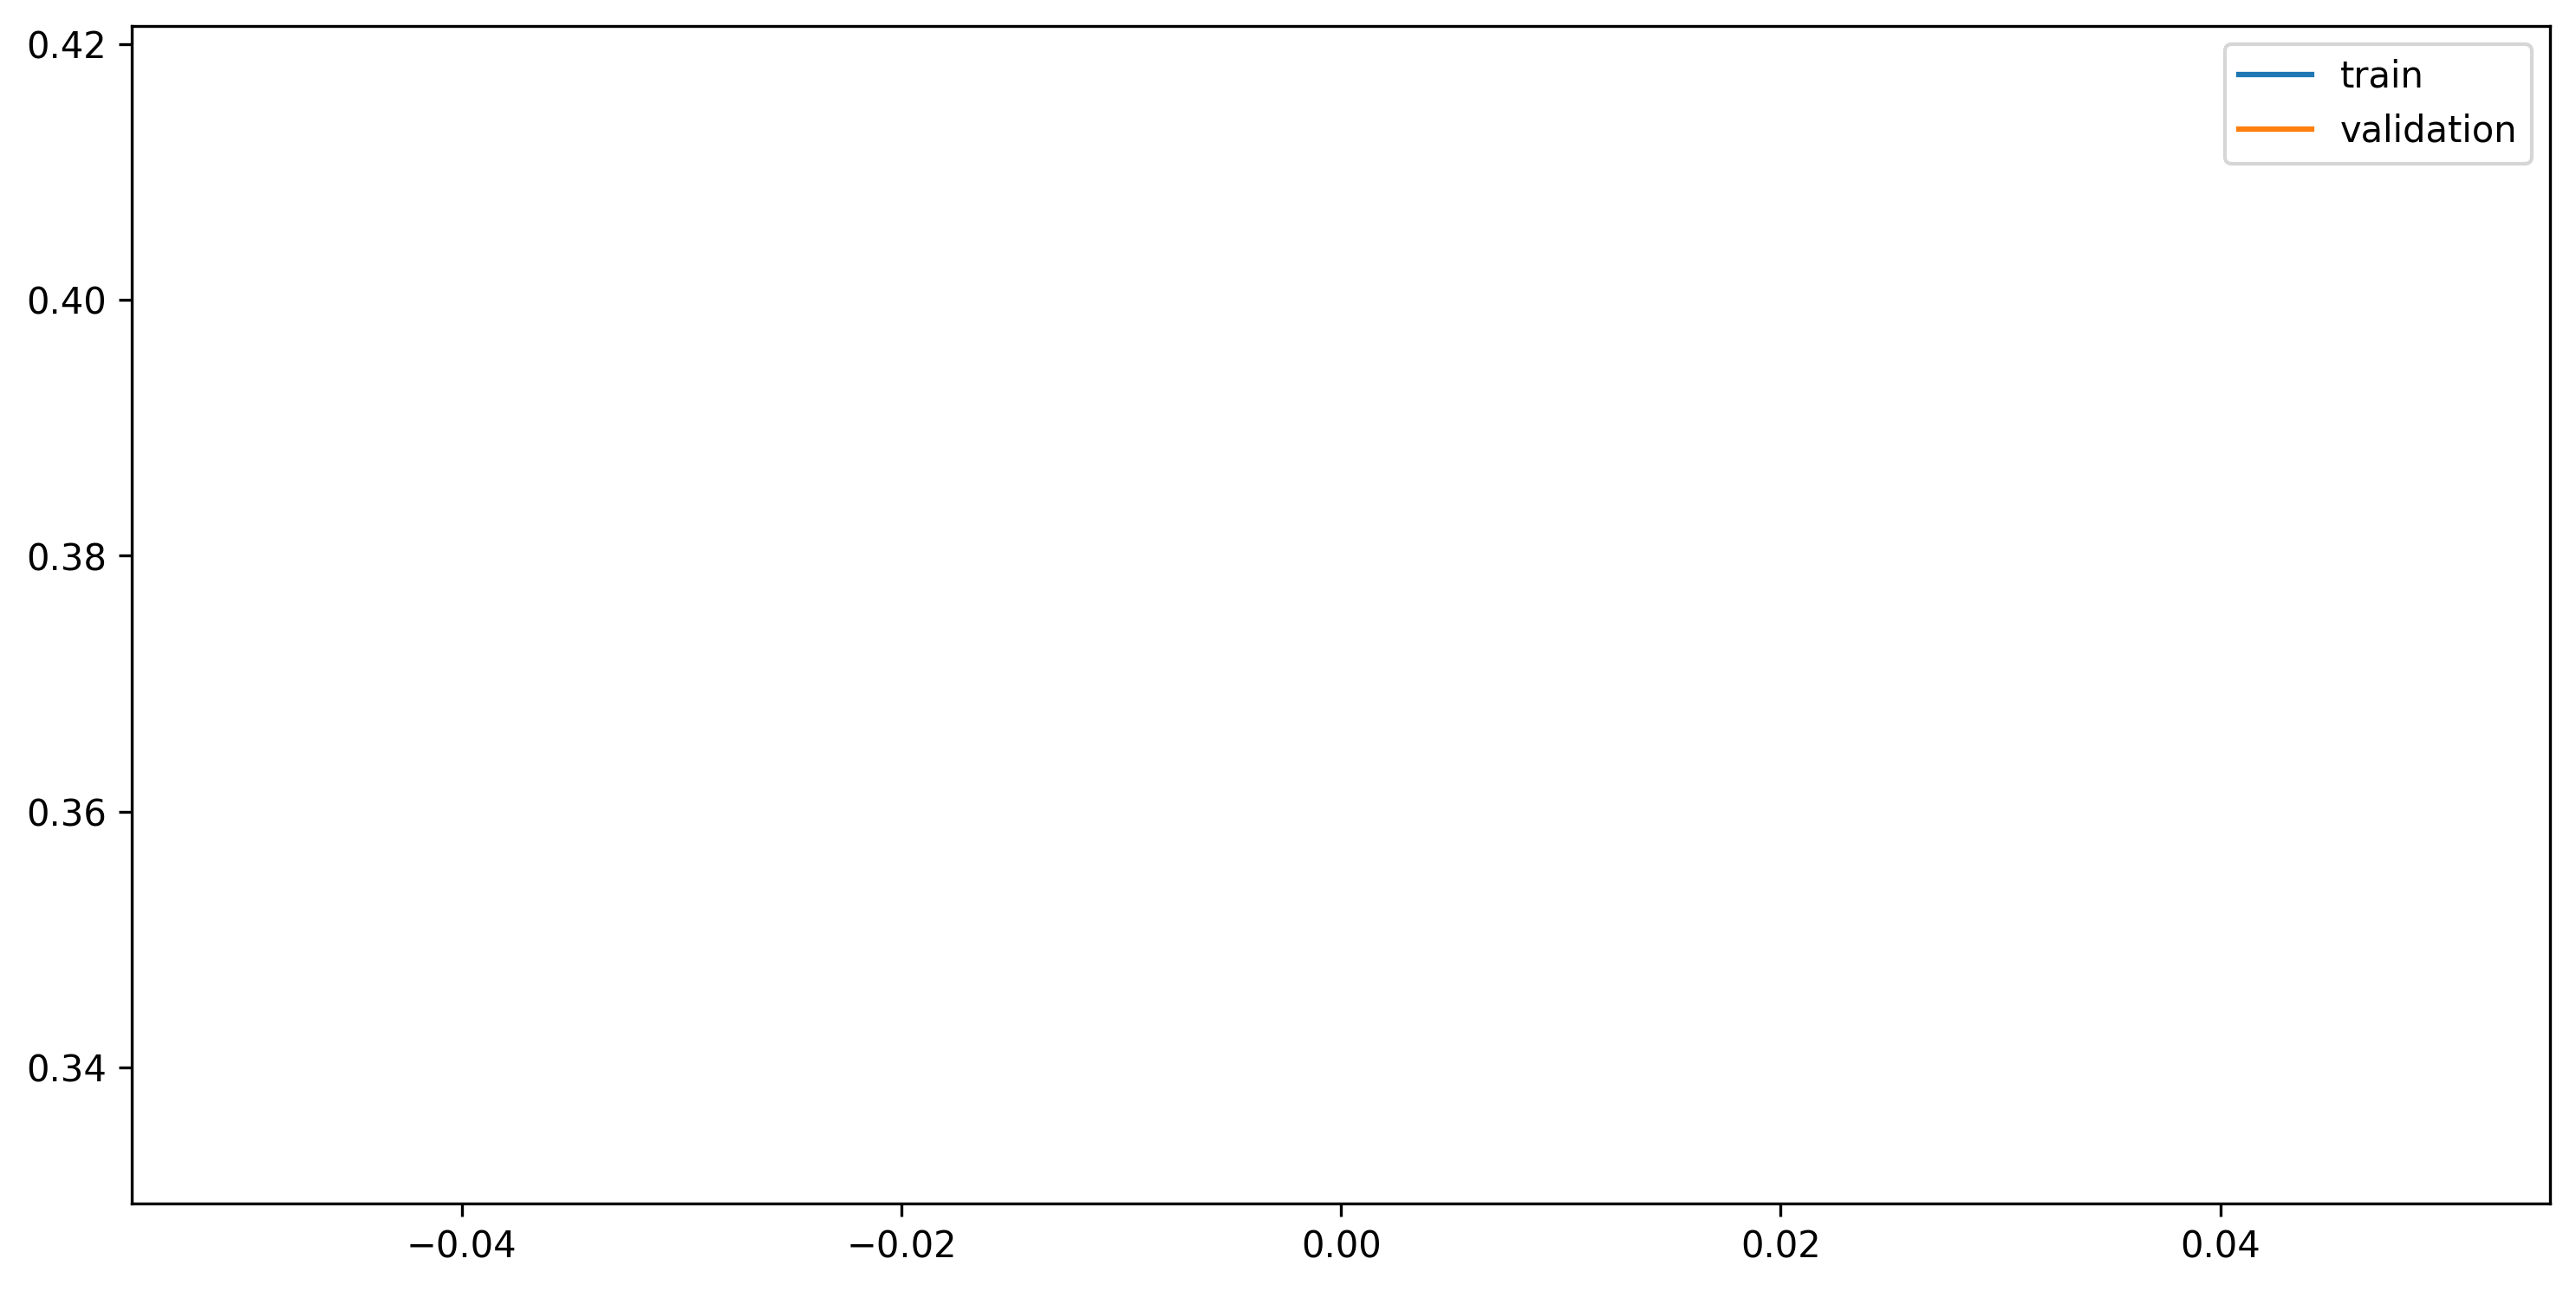

In [20]:
plt.figure(figsize=[12,6], dpi=300)
sns.lineplot(x=list(range(len(history.history['accuracy']))),
             y=history.history['accuracy'],
             label='train')
sns.lineplot(x=list(range(len(history.history['val_accuracy']))),
             y=history.history['val_accuracy'],
             label='validation')
plt.show()

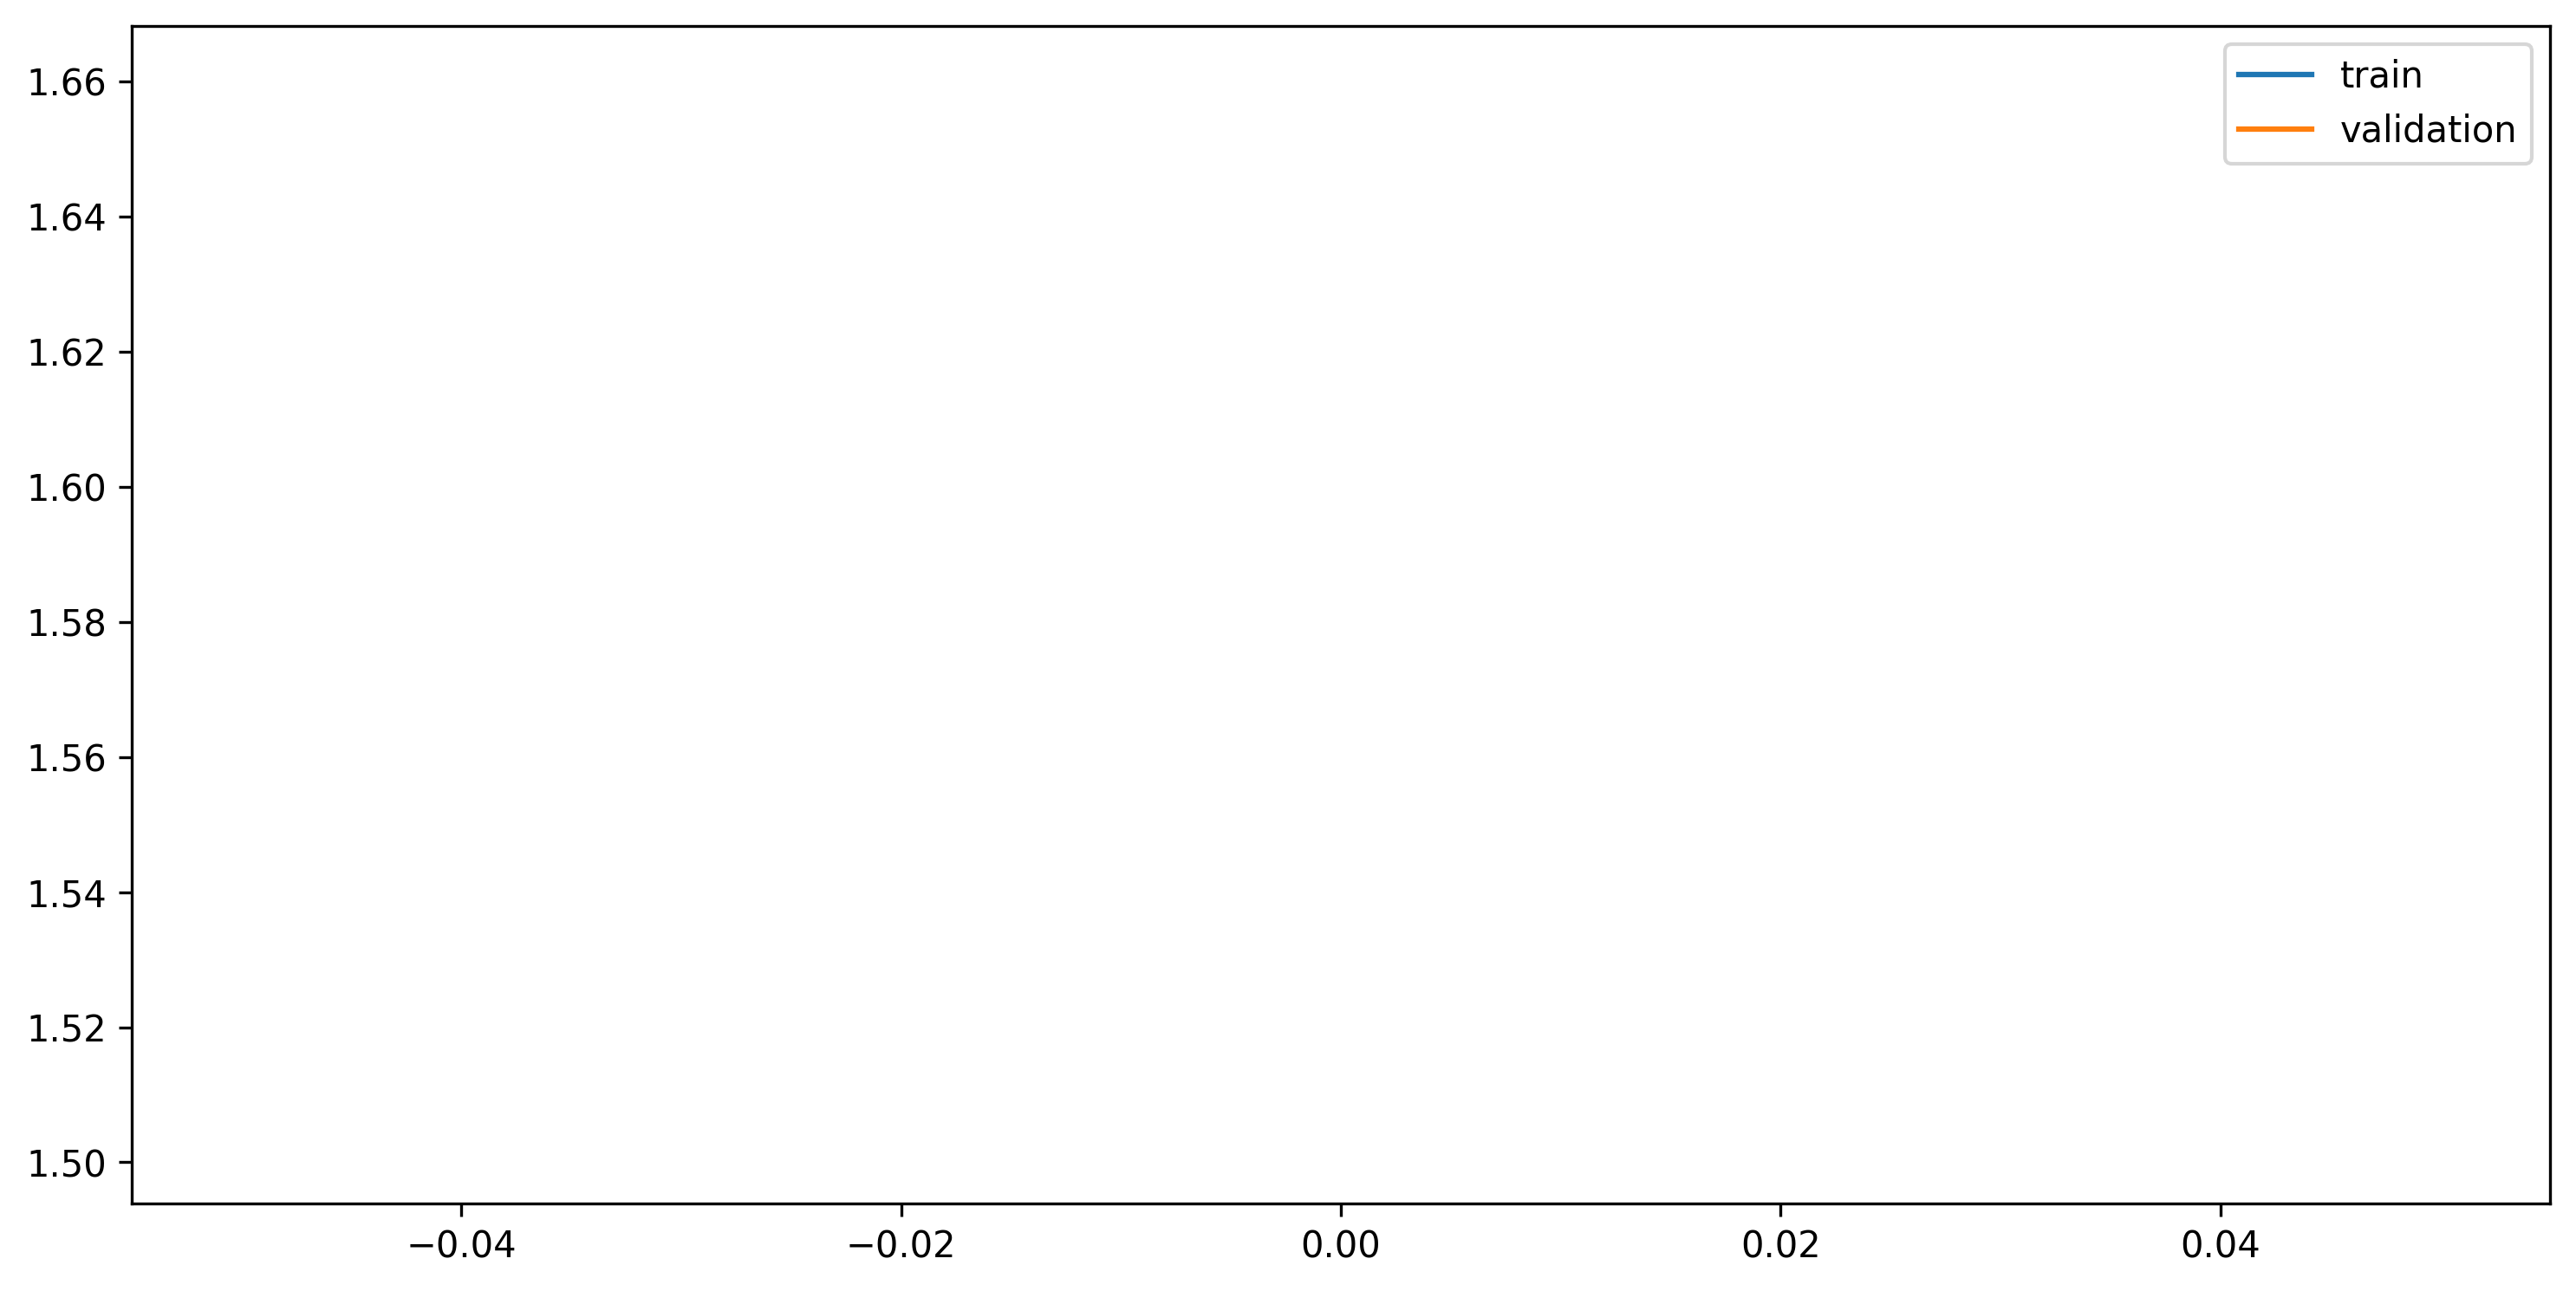

In [21]:
plt.figure(figsize=[12,6], dpi=300)
sns.lineplot(x=list(range(len(history.history['loss']))),
             y=history.history['loss'],
             label='train')
sns.lineplot(x=list(range(len(history.history['val_loss']))),
             y=history.history['val_loss'],
             label='validation')
plt.show()

### save files

In [22]:
temp = pd.DataFrame(history.history)
temp.to_csv('model_effnet_history.csv', index=False)

In [23]:
model.save('model_effnet.hdf5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
